## Config

In [1]:
import os
import re
import pandas as pd
import numpy as np
import random
import nltk
import spacy
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import itertools
from itertools import chain

from platform import python_version
print("VERSION: ", python_version()) # expect 3.7.0

# dirty spaCy error workaround:
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

VERSION:  3.7.0


In [2]:
os_path = '/Users/milk/Desktop/git/'
forms_dir = os_path + 'InformedConsentForms/data/all_forms'

In [3]:
nlp = spacy.load('en')
nlp_larg = spacy.load('en_core_web_lg')

## Semantic Clues

In [4]:
##  taken from: 
# “I found great synonyms for ‘permission’ on the new Thesaurus.com!,”
# www.thesaurus.com. [Online]. Available: https://www.thesaurus.com/browse/permission. 
## [Accessed: 19-Feb-2019].

permission_bases = ["permission", 
                    "authorization", 
                    "authorize",
                    "consent",
                    "assent",
                    "permit",
                    "approve",
                    "grant",
                    "allow",
                    "certify"]

## add synonyms

In [5]:
def addWordNetSynsets(word_list):
    " add synsets to new list "
    updated_list = []
    
    for word in word_list:
        updated_list.append(word)
        synonyms = wordnet.synsets(word, 'v')
        synonyms = set(chain.from_iterable([word.lemma_names() for word in synonyms]))
        
        [updated_list.append(x) for x in synonyms if x not in updated_list]
        
    return updated_list
        
permission_extended = addWordNetSynsets(permission_bases)
print('num elements:', len(permission_extended))
# [print(x) for x in permission_extended]

num elements: 51


## build consent form data structure
get dict and dataframe from each consent form on file

#### todo: get metadata

In [6]:
def getData(directory):
    """ returns a dict with cleaned filenames, full paths,
    and text data in multiple formats from a dictionary
    of .txt files"""
    
    fileDictionary = {}
    fileID = 0
    
    # iterate through directory
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            
            fileID += 1
            filepath = subdir + os.sep + file
            
            if filepath.endswith('.txt'):
                wordList = [] # this will include duplicates and stop words
                cleanedFileName = ''.join(e for e in file if e.isalnum())[:-3] 
                
                # perform string operations on each file
                with open(filepath, 'r') as myfile:
                    data = myfile.read().replace('\n', ' ')       
                
                fileDictionary[fileID] = {}
                fileDictionary[fileID]['name'] = cleanedFileName
                fileDictionary[fileID]['path'] = filepath
                fileDictionary[fileID]['rawText'] = data
    
    return fileDictionary

# run the function and store to variable 
consent_dictionary = getData(forms_dir)

# #test print statement
# [print(k,v, '\n') for k,v in consent_dictionary[1].items()]

In [7]:
def toDataFrame(fileDictionary):
    """ return pandas dataframe
    Note: expects input in nested dict format (output from getData)"""
    new_rows = []

    for key, value in fileDictionary.items():
        new_rows.append(value)
         
    df = pd.DataFrame(new_rows)
    return df

## Random sampling to develop
This will be removed when we want to process the whole corpus

In [8]:
df = toDataFrame(consent_dictionary)

print(df.columns)

n_samples = 50
df = df.sample(n=n_samples)

Index(['name', 'path', 'rawText'], dtype='object')


## add spacy object to dataframe

#### WARNING: this takes a long time,

In [9]:
def getDocObjects(row, field):
    " return spacy doc object"
#     # small nlp library
#     doc = nlp(str(row[field]).lower())
    # large library
    doc = nlp_larg(str(row[field]).lower())
    return doc

# here we only convert the first 10 rows to save time
df['docOB'] = df.apply(lambda row:getDocObjects(row, 'rawText'),axis=1)

In [10]:
df['docOB'].head()

423    (﻿,                                          ,...
467    (addendum, to, hpv, (, human, papillomavirus, ...
412    (﻿, delete, the, red, text, prior, to, submitt...
621    (brushy, creek, family, physicians, patient, h...
346    (﻿instructions, no, more, than, minimal, risk,...
Name: docOB, dtype: object

## extract sentences

In [11]:
def getSentenceList(row, field):
    " return list of sents from doc object"
    sent_list = []
    
    # must operate on a spaCy doc object 
    for sent in row[field].sents:
#         print(dir(sent))
        sent_list.append(sent)
    
    return sent_list

# here we only convert the first 10 rows to save time
df['sentList'] = df.apply(lambda row:getSentenceList(row, 'docOB'),axis=1)

In [12]:
# print(df['sentList'].head())

# print()

# for sentList in df['sentList'].head(11):
#     print(len(sentList))

## preliminary permisison sentence extraction
look for sentences that have a word from the 'clues' list

In [13]:
# for sentList in df['sentList'].head(11):
#     for sent in sentList:
#         for clue in permission_extended:
#             if sent.text.__contains__(clue): # note, we're dealing with spaCy object
#                 print('SENTENCE:', sent, '\n')

In [14]:
def getPossiblePermissions(row, permissions_list):
    """ return list of sentences containing the 
    permissions words """
    
    sent_list = []
    
    for sent in row['sentList']:
        [sent_list.append(sent) for clue in\
             permission_extended if sent.text.__contains__(clue)]
                
    return sent_list

# here we only convert the first 10 rows to save time
df['permissionsStatements'] = df.apply(lambda row:getPossiblePermissions(row, permission_extended),axis=1)

In [15]:
for sent in df['permissionsStatements'][:10]:
    [print('sent:', x.text, '\n') for x in sent[:2]]

sent: statement of consent "the purpose of this study, procedures to be followed, risks and benefits have been explained to me.   

sent: i have been allowed to ask questions, and my questions have been answered to my satisfaction.   

sent: i have had a chance to ask questions about the disease the vaccine prevents, the vaccine, and how the vaccine is given. 

sent: i am an adult who can legally consent for the person named below to get the vaccine. 

sent: ﻿ delete the red text prior to submitting this form to the irb. 

sent: sample language is in italics required language is in regular text  authorization form for use and disclosure of protected health information (phi) for research  project title:    the united states government has issued a new privacy rule to protect the privacy rights of individuals enrolled in research.   

sent: brushy creek family physicians patient hipaa acknowledgment and consent form patient name: 

sent: i acknowledge that i have received the practice’s 

In [16]:
def getEstimatedPermissionDesnity(row):
    """ return proportion of sentence total that may
    be statements indicating perissions. Expect much noise. """
     
    return len(row['permissionsStatements'])/len(row['sentList'])
    
df['permissionDensity'] = df.apply(lambda row: getEstimatedPermissionDesnity(row),axis=1)

df.head(2)

,name,path,rawText,docOB,sentList,permissionsStatements,permissionDensity
423,BlankeIRBConsentFormTemplateMinors9112013,/Users/milk/Desktop/git/InformedConsentForms/d...,﻿ STA...,"(﻿, ,...","[(﻿, ...","[(statement, of, consent, "", the, purpose, of,...",0.022346
467,TexasHHSAddendumtoHPVVaccineConsent,/Users/milk/Desktop/git/InformedConsentForms/d...,Addendum to HPV (Human Papillomavirus) Vaccine...,"(addendum, to, hpv, (, human, papillomavirus, ...","[(addendum, to, hpv, (, human, papillomavirus,...","[(i, have, had, a, chance, to, ask, questions,...",0.344828


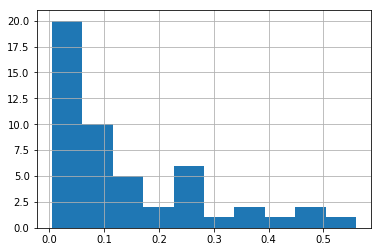

In [17]:
%matplotlib inline
df['permissionDensity'].hist()

## Important
this represents an important break away from the primary dataframe. here i start to work with list structures to create a list of possible permissions that is no longer tied to filenames

In [18]:
all_sents = []

for sentlist in df['sentList'].to_list():
    [all_sents.append(x) for x in sentlist]
    
all_permissions = []

for permlist in df['permissionsStatements'].to_list():
    [all_permissions.append(x) for x in permlist]

In [19]:
print('total rough draft permissions: ', len(all_permissions))
print('unique rough draft permissions: ', len(list(set(all_permissions))))

print('total rough draft sentences: ', len(all_sents))
print('unique rough draft sentences: ', len(list(set(all_sents))))

total rough draft permissions:  1755
unique rough draft permissions:  1404
total rough draft sentences:  26124
unique rough draft sentences:  26124


In [20]:
# remove duplucates
all_permissions = list(set(all_permissions))

## pair-wise similarity between our permission 'guesses' and remaining sentences
this is an important step so that we don't restrict ourselves to permission statements that contain the words we dreampt up

#### warning, this is not a good algorithm, will not scale

In [21]:
new_rows = []

for sent in all_sents:
    for perm in all_permissions:
        row = {
            'permission':perm,
            'sentence':sent,
            'similarity':sent.similarity(perm)
        }
        new_rows.append(row)

In [22]:
sf = pd.DataFrame(new_rows)
sf.head()

,permission,sentence,similarity
0,"(’s, legally, authorized, representative, \t, ...","(﻿, )",0.0
1,"(authorization, )","(﻿, )",0.0
2,"(anderson, will, take, appropriate, steps, to,...","(﻿, )",0.0
3,"(consent, form, for, phase, i, portion, of, st...","(﻿, )",0.0
4,"(i, have, read, this, consent, form, ., )","(﻿, )",0.0


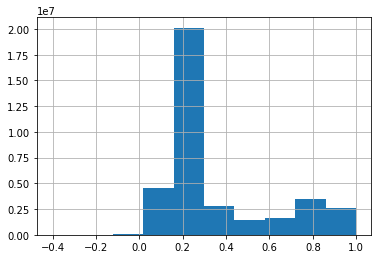

In [23]:
sf['similarity'].hist()

In [24]:
# reduce dataframe, aggregate by mean sim score (weak sents will balance out)
sf = sf.drop(columns=['permission'])
sf = sf.groupby(['sentence'], as_index=False).mean()

sf.head()

,sentence,similarity
0,"(﻿, )",0.000000
1,(patient),0.503442
2,"(partners, healthcare, system, , research, ...",0.811238
3,"(mri, screening, and, consent, form, , prefer...",0.737874
4,"(', joseph, 's, , patient, i)",0.621505


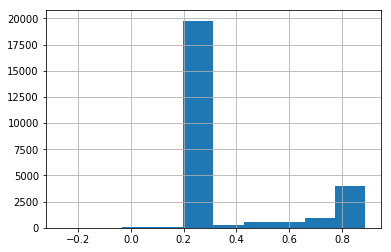

In [25]:
sf['similarity'].hist()

In [26]:
high_sim = sf[sf.similarity > .7]
candidates = high_sim['sentence'].to_list()

In [27]:
print('total rough draft candidates: ', len(candidates))
print('unique rough draft candidates: ', len(list(set(candidates))))

total rough draft candidates:  4694
unique rough draft candidates:  4694


In [28]:
[print('sent: ', x, '\n') for x in candidates[:10]]

sent:  partners healthcare system    research consent form  redcap:      biobank:    research tissue bank  subject identification  version date: february 2010      protocol title: biorepository of the institute for heart, vascular and stroke care in collaboration with the partners healthcare biobank (partners biobank)     

sent:  mri screening and consent form  preferred name:   

sent:  picc consent procedure information: a physician/licensed professional has ordered the insertion of a picc. 

sent:  ﻿greater than minimal risk template instructions  greater than minimal risk template. 

sent:  lorain county health & dentistry parental consent for dental care and the use of safety steps  all efforts will be made to obtain the cooperation for dental treatment from your child including warmth, friendliness, persuasion, humor and understanding. 

sent:  ﻿sample short form written consent document  for subjects who do not speak english  this document must be written in a language and styl

[None, None, None, None, None, None, None, None, None, None]

In [29]:
rough_draft_permissions = all_permissions + candidates

In [30]:
print('total rough draft candidates: ', len(rough_draft_permissions))
print('unique rough draft candidates: ', len(list(set(rough_draft_permissions))))

total rough draft candidates:  6098
unique rough draft candidates:  4788


In [31]:
rough_draft_permissions = list(set(rough_draft_permissions))

## print statements to file

In [32]:
import csv
import datetime
today = str(datetime.date.today())

file_path = 'statements-'+today+'.csv'
print(file_path)

with open(file_path, 'a') as outcsv:   
    #configure writer to write standard csv file
    writer = csv.writer(outcsv, delimiter=',', quoting=csv.QUOTE_MINIMAL, lineterminator='\n')
    writer.writerow(['raw_text', 'clean_text'])
    for perm in rough_draft_permissions:
        #Write item to outcsv
        raw_text = perm.text
        clean_text = re.sub('\s+', ' ', re.sub('\W+',' ',\
                               re.sub('[^A-Za-z0-9]+',' ', \
                                      re.sub(r'\d+', " ", raw_text)))).strip()
        writer.writerow([raw_text, clean_text])

statements-2019-02-27.csv
